<a href="https://colab.research.google.com/github/yinghaow525/MSBA-Projects/blob/main/Capstone%20Project/Capstone_A6_Coding_Deliverable_05_Time_Series_Foracasting_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capsone Project with Spinnaker Analytics
Team A6: Yihan Jia, Yinghao Wang, Simeng Li, Xiangshan Mu, Kaiyu Wang
> **Business Objectives**:
- The objective of the exercise is to find a tradable signal in the dataset. 

> **Project Flow**:
- Standard time series models can be used or non-parametric models like neural networks can be deployed. Suggested course of actions is as follows:
  1. Understand the dataset and what it represents
  2. Define the problem: what does 'a tradable signal' mean based on the data available (i.e. develop your modeling equation, if any)
  3. Start with simple analysis to identify patterns and outliers
  4. Develop models with increasing complexity - i.e. don't start with neural nets etc
  5. Define your success criteria - i.e. when do you know you have a tradable signal - positive (buy)/negative (sell), both are signals


In [ ]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from google.colab import drive

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.api import ExponentialSmoothing

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from statsmodels.tsa.arima_model import ARIMA


#reset recursionlimit
import sys
sys.setrecursionlimit(10000)

import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable

# supress filter warnings
import warnings
warnings.filterwarnings("ignore")

#plt style
plt.style.use("seaborn")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# read datasets

ETF = pd.read_csv('https://raw.githubusercontent.com/yinghaow525/MSBA-Projects/main/Capstone%20Project/Datasets/US%20Sector%20Inst%20ETF.csv')
IMF = pd.read_csv('https://raw.githubusercontent.com/yinghaow525/MSBA-Projects/main/Capstone%20Project/Datasets/US%20Sector%20Institutional%20MF.csv')
RMF = pd.read_csv('https://raw.githubusercontent.com/yinghaow525/MSBA-Projects/main/Capstone%20Project/Datasets/US%20Sector%20Retail%20MF.csv')

In [ ]:
# Create type colunm
ETF['Type'] = 'ETF'
IMF['Type'] = 'IMF'
RMF['Type'] = 'RMF'

# Concat 3 dadaset
data = pd.concat([ETF, IMF, RMF], axis=0)

In [ ]:
# convert report date to pandas datetime object
data['ReportDate'] = pd.to_datetime(data['ReportDate'])

In [ ]:
# since all the Asset and Sector values are the same (Equity, and within US)
# we only keep Industry sector as features
data['AssetClass'] = data['AssetClass'].str.split('-')
data['Industry'] = data.AssetClass.apply(lambda x: x[0])

# drop orignal AssetClass feature
data.drop(columns='AssetClass', inplace=True)

In [ ]:
# extract year & month 
data['year'], data['month'] = data['ReportDate'].dt.year, data['ReportDate'].dt.month

# Time Series Analysis - 2


## LSTM estimations
Long Short Term Memory from Recurrent Neural Network architectures.

In [ ]:
# drop all rows where industry == Infrastructure
df = data.drop(data[data['Industry'] == 'Infrastructure'].index)

In [ ]:
data.Type.unique()

array(['ETF', 'IMF', 'RMF'], dtype=object)

In [ ]:
data.Industry.unique()

array(['Commodities/Materials', 'Consumer Goods', 'Energy', 'Financials',
       'Health Care/Biotech', 'Industrials', 'Large Cap Blend',
       'Large Cap Growth', 'Large Cap Value', 'Mid Cap Blend',
       'Mid Cap Growth', 'Mid Cap Value', 'Real Estate',
       'Small Cap Blend', 'Small Cap Growth', 'Small Cap Value',
       'Technology', 'Telecom', 'Utilities', 'Infrastructure'],
      dtype=object)

In [ ]:
# exclude industries with missing data observations
industries = ['Energy', 'Financials',
       'Health Care/Biotech', 'Large Cap Blend',
       'Large Cap Growth', 'Large Cap Value', 'Mid Cap Blend',
       'Mid Cap Growth', 'Mid Cap Value', 'Real Estate',
       'Small Cap Blend', 'Small Cap Growth', 'Small Cap Value',
       'Technology', 'Telecom', 'Utilities']

In [ ]:
len(industries)

16

In [ ]:
LSTM_ETF=data[data['Type']== 'ETF']

In [ ]:
LSTM_ETF.head(3)

,ReportDate,Flow,FlowPct,AssetsEnd,PortfolioChangePct,Type,Industry,year,month
0,2017-02-01,378.578706,4.5064,8679.056347,-1.1938,ETF,Commodities/Materials,2017,2
1,2017-02-01,332.526792,1.1479,28973.613065,-1.1231,ETF,Consumer Goods,2017,2
2,2017-02-01,186.031374,0.3782,48446.700077,-1.8855,ETF,Energy,2017,2


In [ ]:
LSTM_ETF_energy=LSTM_ETF[LSTM_ETF['Industry']=='Energy']

In [ ]:
LSTM_ETF_energy.head(3)

,ReportDate,Flow,FlowPct,AssetsEnd,PortfolioChangePct,Type,Industry,year,month
2,2017-02-01,186.031374,0.3782,48446.700077,-1.8855,ETF,Energy,2017,2
21,2017-01-25,242.309208,0.5019,49187.639104,1.3951,ETF,Energy,2017,1
40,2017-01-18,237.672693,0.4934,48270.885205,-0.2861,ETF,Energy,2017,1


In [ ]:
LSTM_ETF_energy = LSTM_ETF_energy.sort_values(by='ReportDate', ascending=True)

In [ ]:
LSTM_ETF_energy.head(3)

,ReportDate,Flow,FlowPct,AssetsEnd,PortfolioChangePct,Type,Industry,year,month
10986,2006-01-04,12.115391,0.7262,1756.771759,4.5757,ETF,Energy,2006,1
10967,2006-01-11,16.227106,0.9236,1808.084925,1.9971,ETF,Energy,2006,1
10948,2006-01-18,20.685026,1.1440,1846.248449,0.9666,ETF,Energy,2006,1


In [ ]:
input_data=LSTM_ETF_energy[['FlowPct','AssetsEnd','PortfolioChangePct','Flow']]

In [ ]:
input_data=input_data.reset_index(drop=True)

In [ ]:
input_data.head(3)

,FlowPct,AssetsEnd,PortfolioChangePct,Flow
0,0.7262,1756.771759,4.5757,12.115391
1,0.9236,1808.084925,1.9971,16.227106
2,1.1440,1846.248449,0.9666,20.685026


In [ ]:
X = input_data.iloc[:, :-1]
y = input_data.iloc[:, 3:4] 

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [ ]:
#first 550 for training

X_train = X_ss[:550, :]
X_test = X_ss[550:, :]

y_train = y_mm[:550, :]
y_test = y_mm[550:, :] 

In [ ]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (550, 3) (550, 1)
Testing Shape (29, 3) (29, 1)


In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [ ]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [ ]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([550, 1, 3]) torch.Size([550, 1])
Testing Shape torch.Size([29, 1, 3]) torch.Size([29, 1])


In [ ]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [ ]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 3 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [ ]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 

In [ ]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [ ]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.18833
Epoch: 100, loss: 0.00347
Epoch: 200, loss: 0.00240
Epoch: 300, loss: 0.00195
Epoch: 400, loss: 0.00133
Epoch: 500, loss: 0.00075
Epoch: 600, loss: 0.00044
Epoch: 700, loss: 0.00023
Epoch: 800, loss: 0.00011
Epoch: 900, loss: 0.00009


In [ ]:
df_X_ss = ss.transform(input_data.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(input_data.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

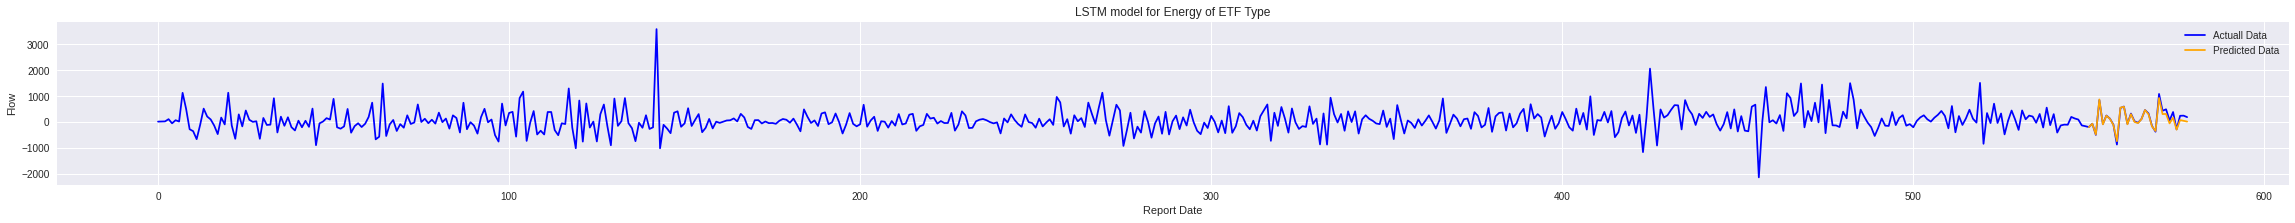

In [ ]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(40,3)) #plotting

plt.plot(dataY_plot, label='Actuall Data', c = 'b') #actual plot
plt.plot(range(550, 550+len(data_predict[550:])),data_predict[550:], label='Predicted Data',c='orange') #predicted plot
plt.title('LSTM model for Energy of ETF Type')
plt.xlabel('Report Date')
plt.ylabel('Flow')
plt.legend()
plt.show()